In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import integrate

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def temp_from_photons(ω_c, num_photons):
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [4]:
def photons_from_temp(ω_c, temp):
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

In [5]:
def full_mean_photons_cav(κ, γ, r, g, nT, nc):
    a = (κ + γ)
    b = r * g ** 2 / ((r/2) ** 2 + (r / 2) * ((κ + γ) / 2) + g ** 2)
    num = a * nT + b * nc

    den = a + b

    return num / den

In [6]:
def cav_spectrum(ω, κ, γ, r, g, nT, nc, Δ):
    a = ((r ** 2 / 4) + ω ** 2) * (κ + γ) * nT
    b = r * g ** 2 * nc

    den = np.abs(((κ + γ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    return (a + b) / den

In [7]:
# Define parameters
ωc = 2.87 * 2 * np.pi * 1e9
κ = 0
P = 0.8
nc = 0.5 * (1 - P) / P
T = 5
nT = photons_from_temp(ωc, T)

In [8]:
# Define sweep parameters
g = np.logspace(4, 7, 1000)
Q = np.logspace(4, 7, 1000)

# Create meshgrid
gm, Qm = np.meshgrid(g, Q)

# Calculate r and γ
r = 2 * gm
γ = ωc / Qm

In [9]:
# Calculate the number of photons
nbar = full_mean_photons_cav(κ, γ, r, gm, nT, nc)

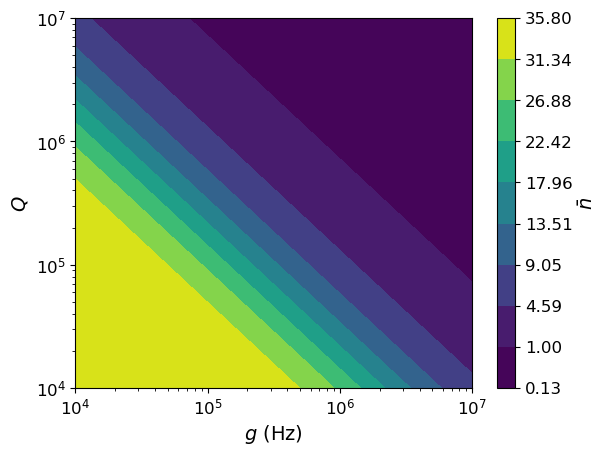

In [10]:
plt.contourf(gm, Qm, nbar, [nbar.min(), 1, 4.59, 9.05, 13.51, 17.96, 22.42, 26.88, 31.34, nbar.max()])
plt.xlabel("$g$ (Hz)")
plt.ylabel("$Q$")
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='$\\bar{n}$')
plt.savefig("nbar_vs_gQ_P=1.png", format='png', dpi=300)

In [11]:
P_vals = np.linspace(0.1, 1, 1000)
nc_vals = 0.5 * (1 - P_vals) / P_vals

In [12]:
# Define g and Q values we want to use here
g_vals = np.array([1e5, 1e6, 1e7])
Q_vals = np.array([1e5, 1e6, 1e7])

# Set up list for storing nbar values
nbars = []

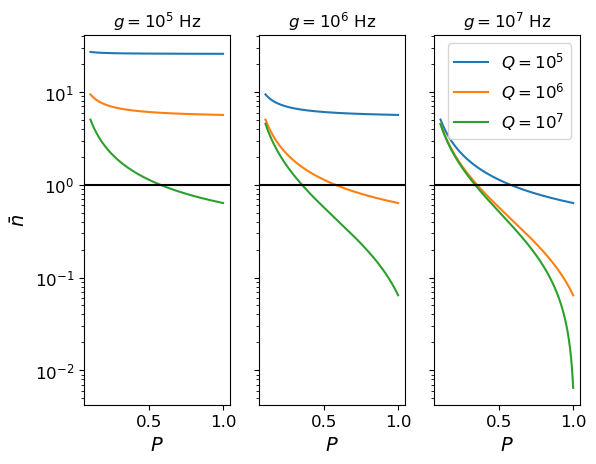

In [13]:
fig = plt.figure(1)
ax = fig.subplots(1, 3, sharey='all')
for i in range(g_vals.shape[0]):
    nbars = []
    for j in range(Q_vals.shape[0]):
        nbars.append(full_mean_photons_cav(κ, ωc / Q_vals[j], 2*g_vals[i], g_vals[i], nT, nc_vals))
        ax[i].semilogy(P_vals, nbars[j], label="$Q=10^" + str(j+5) + "$")
    ax[i].set_xlabel("$P$")
    #ax[i].set_xticks([0.5, 1])
    ax[i].axhline(y=1, color='k')
ax[0].set_ylabel("$\\bar{n}$")
#ax[0].text(0.075, 0.01, '(a)')
#ax[1].text(0.075, 0.01, '(b)')
#ax[2].text(0.075, 0.01, '(c)')
ax[0].set_title("$g=10^{5}$ Hz")
ax[1].set_title("$g=10^{6}$ Hz")
ax[2].set_title("$g=10^{7}$ Hz")
ax[2].legend()
fig.savefig("nbar_vs_P_for_diff_gQ.png", format='png', dpi=300)

In [14]:
# Want to determine more precisely the polarization required to get below nbar = 1
for i in range(g_vals.shape[0]):
    for j in range(Q_vals.shape[0]):
        for k in range(P_vals.shape[0]):
            n = full_mean_photons_cav(κ, ωc / Q_vals[j], 2*g_vals[i], g_vals[i], nT, nc_vals[k])
            if n < 1:
                print("g=" + str(g_vals[i]) + ", Q=" + str(Q_vals[j]) + ", P=" + str(P_vals[k]))
                break
    

g=100000.0, Q=10000000.0, P=0.5756756756756757
g=1000000.0, Q=1000000.0, P=0.5756756756756757
g=1000000.0, Q=10000000.0, P=0.34864864864864864
g=10000000.0, Q=100000.0, P=0.5756756756756757
g=10000000.0, Q=1000000.0, P=0.34864864864864864
g=10000000.0, Q=10000000.0, P=0.33513513513513515


In [15]:
P = 0.8
nc = 0.5 * (1 - P) / P
g = 1e7
r = 2 * g
Q = 1e7
n = full_mean_photons_cav(κ, ωc / Q, 2*g, g, nT, nc)
print(n)

0.13143219876717652


Matt suggested seeing if we could use cooperativity as our parameter of interest instead, as it relates g to Q.  Then $C = \frac{g^2}{(\kappa+\gamma)r} = \frac{Qg}{Q\kappa+\omega_c}\frac{g}{r}$.  If $\kappa=0$ and $r=\alpha g$, then $C = \frac{gQ}{\alpha \omega_c}$.

In [16]:
C = gm ** 2 / ((κ + γ) * r)

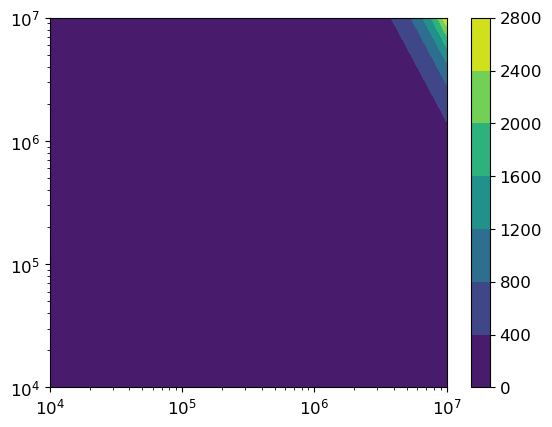

In [17]:
plt.contourf(gm, Qm, C)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

In [18]:
# Redefine γ and r for this calculation
g = np.logspace(4, 7, 1000)
r = g
γ = ωc / np.array([1e4, 1e5, 1e6, 1e7])

In [19]:
nbars = np.array([full_mean_photons_cav(κ, _, r, g, nT, nc) for _ in γ])

In [20]:
C = np.array([g ** 2 / ((κ + _) * r) for _ in γ])

In [21]:
nbars.shape, C.shape

((4, 1000), (4, 1000))

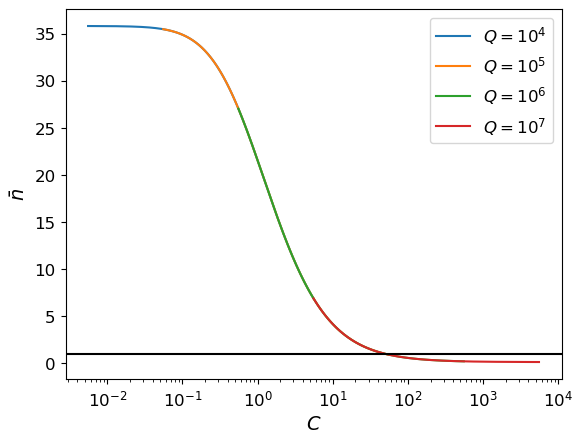

In [22]:
for i in range(γ.shape[0]):
    plt.plot(C[i], nbars[i], label='$Q=10^{'+str(i+4)+"}$")
plt.axhline(y=1, color='k')
plt.xlabel("$C$")
plt.ylabel("$\\bar{n}$")
plt.xscale('log')
plt.legend()

Text(0, 0.5, '$\\bar{n}$')

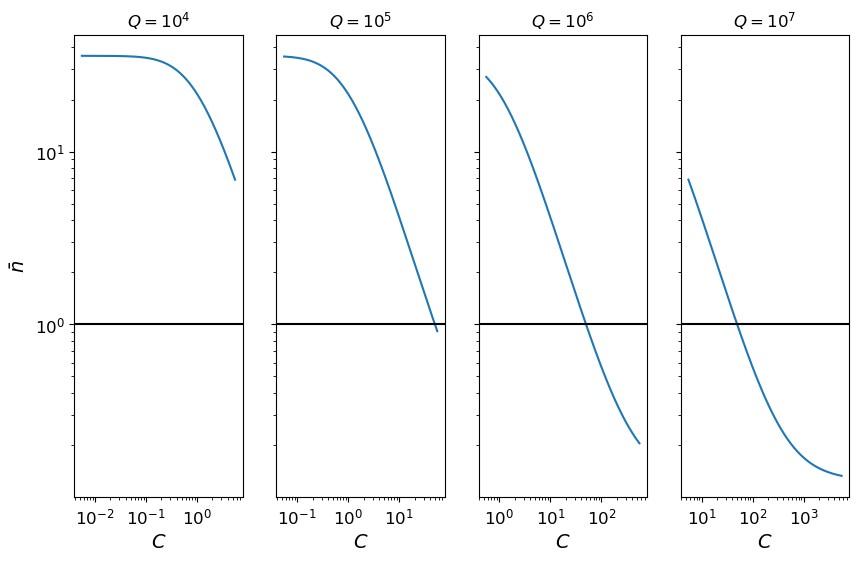

In [23]:
fig = plt.figure(1, figsize=(10,6))
ax = fig.subplots(1, 4, sharey='all')
for i in range(γ.shape[0]):
    ax[i].loglog(C[i], nbars[i])
    ax[i].set_xlabel("$C$")
    ax[i].axhline(y=1, color='k')
    ax[i].set_title("$Q=10^{" + str(i+4) + "}$")
ax[0].set_ylabel("$\\bar{n}$")


Seems like this might work as a figure, but I'm not sure that its more informative than the other

In [24]:
# Chuck's paper suggests some values for the diffraction scaled mode volume Vb
vb = 3.93998e-6
Bs = np.sqrt(6.626e-34 * (ωc / (2 * np.pi))  / (2 * vb / 1.26e-6))
print("Magnetic field: ", str(Bs) + " T")

# Undo the diffraction scaling by multiplying by λ^3
λ = 3e8 * (2 * np.pi / ωc)
mode_vol = vb * λ ** 3
print("Mode volume: ", str(mode_vol) + " m^3")

# Assuming that the volume of the diamond is the same as the mode volume, we can calculate the number of NV centers and then
# the collective coupling
diam_dens = 3.53e6 # g / m^3
ρ_NV = 1 # ppb
num_NVs = ρ_NV * 1e-9 * diam_dens * mode_vol / 12.01 * 6.022e23
print("Number of NV centers: %3e" % num_NVs)

# Now we can calculate the estimated coupling strength of 1 spin
gyro_rat = 28e9 # Hz / T
gs = gyro_rat * Bs
print("Single spin coupling strength: ", str(gs) + " Hz")

# If the mode volume is homogenous and all spins interact equally, then the total coupling is just sqrt(N) * gs
g = np.sqrt(num_NVs) * gs
print("Collective coupling strength: ", str(g) + " Hz")

Magnetic field:  5.514294165103096e-13 T
Mode volume:  4.499995621809443e-09 m^3
Number of NV centers: 7.964977e+11
Single spin coupling strength:  0.015440023662288669 Hz
Collective coupling strength:  13779.714886802396 Hz


In [25]:
# Our diamond volume for comparison
vd = 0.003 * 0.003 * 0.0005
print("Our diamond volume: ", str(vd) + " m^3")

Our diamond volume:  4.500000000000001e-09 m^3


In [26]:
vd / λ ** 3

3.939983833333337e-06

In [27]:
# From Chuck's paper, doubly re-entrant designs at this Vb have Q range from about 5e8 to just over 1e9
# Field expulsion designs seem to range from around 2e9 to 5e9
Q = np.logspace(8, 10, 1000)
T = 5
nT = photons_from_temp(ωc, T)
nbar = full_mean_photons_cav(κ, ωc / Q, 2 * g, g, nT, nc)

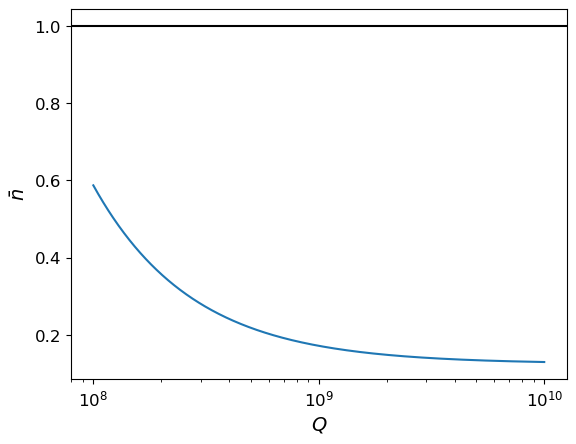

In [28]:
#plt.figure(1, figsize=(8,6))
plt.semilogx(Q, nbar)
plt.axhline(y=1, color='k')
plt.ylabel("$\\bar{n}$")
plt.xlabel("$Q$")
plt.savefig("nbar_vs_Q_supercond.png", format='png', dpi=300)

Chuck's paper suggests that superconducting resonator cavities could achieve a Q of $10^{10}$.  What would the cooling look like then?

In [29]:
Q = 1e10
γ =  ωc / Q

g = np.logspace(1, 8, 1000)
r = g

P = 0.8
nc = 0.5 * (1 - P) / P

In [30]:
nbar_high_Q = full_mean_photons_cav(κ, γ, r, g, nT, nc)

Text(0, 0.5, '$\\bar{n}$')

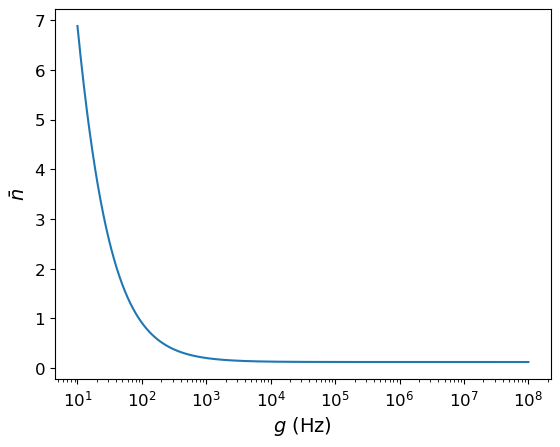

In [31]:
plt.semilogx(g, nbar_high_Q)
plt.xlabel("$g$ (Hz)")
plt.ylabel("$\\bar{n}$")

Create some plots looking at the behavior of mode cooling using r/g instead

In [32]:
# Set our values for g and Q
g = np.array([1e5, 1e6, 1e7, 1e8, 1e9])
Q = np.array([1e5, 1e6, 1e7, 1e8])
γ = ωc / Q

35.79937923012842 35.77938714499701
35.79937923012842 35.600380463201994
35.79937923012842 33.90444699522976
35.79937923012842 22.97891902380251
35.79937923012842 5.522239985395167


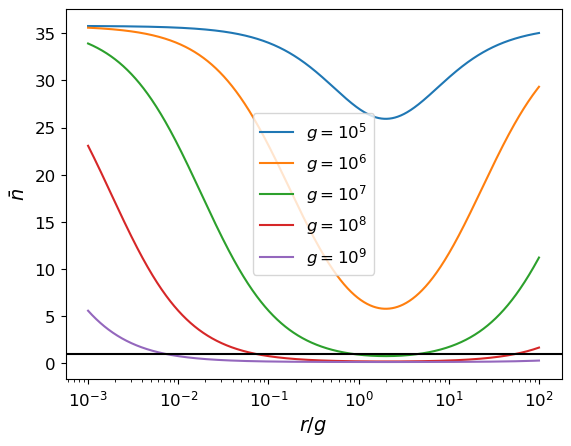

In [33]:
# Create array of r / g values to look at
r_ov_g = np.logspace(-3, 2, 1000)
for i in range(g.shape[0]):
    temp_nbar = full_mean_photons_cav(κ, γ[0], r_ov_g * g[i], g[i], nT, nc)
    print(nT, temp_nbar[1])
    plt.semilogx(r_ov_g, temp_nbar, label="$g=10^"+str(i+5)+"$")

plt.axhline(y=1, color='k')
plt.xlabel("$r/g$")
plt.ylabel("$\\bar{n}$")
plt.legend()

35.79937923012842 35.797364215819655
35.79937923012842 35.7792393251111
35.79937923012842 35.59899830202387
35.79937923012842 33.89199305122189
35.79937923012842 22.922067140749068


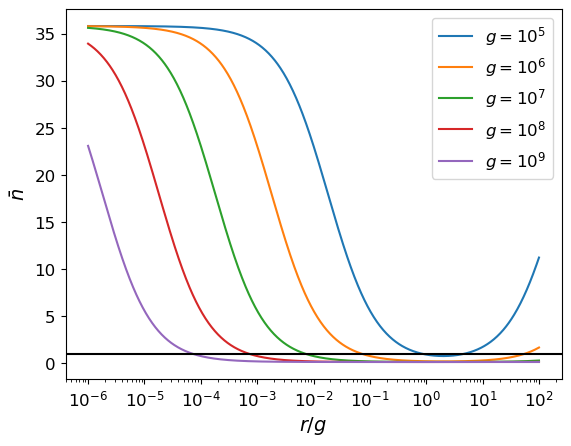

In [34]:
# Create array of r / g values to look at
r_ov_g = np.logspace(-6, 2, 1000)
for i in range(g.shape[0]):
    temp_nbar = full_mean_photons_cav(κ, γ[2], r_ov_g * g[i], g[i], nT, nc)
    print(nT, temp_nbar[1])
    plt.semilogx(r_ov_g, temp_nbar, label="$g=10^"+str(i+5)+"$")

plt.axhline(y=1, color='k')
plt.xlabel("$r/g$")
plt.ylabel("$\\bar{n}$")
plt.legend()

So the higher $g$ gets, the lower you want the ratio $r/g$ to reach the minimum number of photons in the cavity mode.  Increasing $Q$ seems to exacerbate this effect

Kurt suggested looking at $\bar{n}$ in terms of the ratios $\gamma/g$ and $r/g$, turning the problem from having 3 parameters to 2.  If we define $\alpha=\frac{\gamma}{g}$ and $\beta=\frac{r}{g}$, then
$\bar{n} = \frac{\frac{1}{4}\alpha^2\beta n_T + \alpha n_T + \frac{1}{4}\alpha \beta^2 n_T + \beta^2n_c}{\frac{1}{4}\alpha^2\beta + \frac{1}{4}\alpha\beta^2 + \alpha + \beta}$

In [35]:
def two_param_nbar(α, β, nT, nc):
    """
    function for calculating the number of photons in the cavity mode in terms of the ratios (κ + γ) / g = β and r / g = α.
    this function assumes κ = 0, Δ = 0
    """
    num = 0.25 * α ** 2 * β * nT + β * nT + 0.25 * α * β ** 2 * nT + α * nc
    den = 0.125 * α ** 2 * β + 0.125 * α * β ** 2 + 0.5 * (α + β)
    return 1 / 2 * num / den
    

In [36]:
α = np.logspace(-2, 2, 1000)
β = np.logspace(-2, 2, 1000)
αm, βm = np.meshgrid(α, β)
scaled_nbar = two_param_nbar(αm, βm, nT, nc)

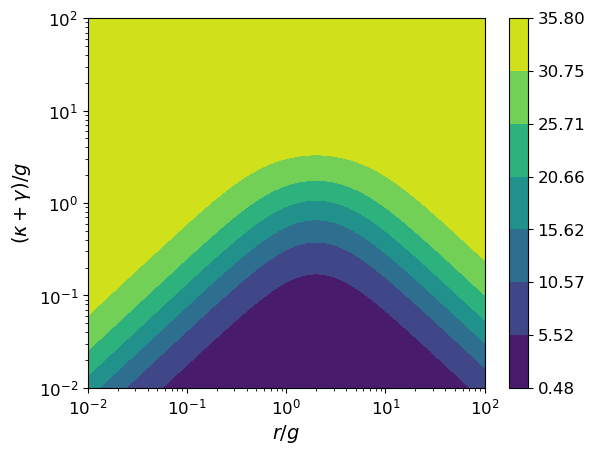

In [37]:
plt.contourf(αm, βm, scaled_nbar, np.linspace(scaled_nbar.min(), scaled_nbar.max(), 8))
plt.xlabel("$r / g$")
plt.xscale("log")
plt.ylabel("$(\\kappa + \\gamma) / g$")
plt.yscale("log")
plt.colorbar()

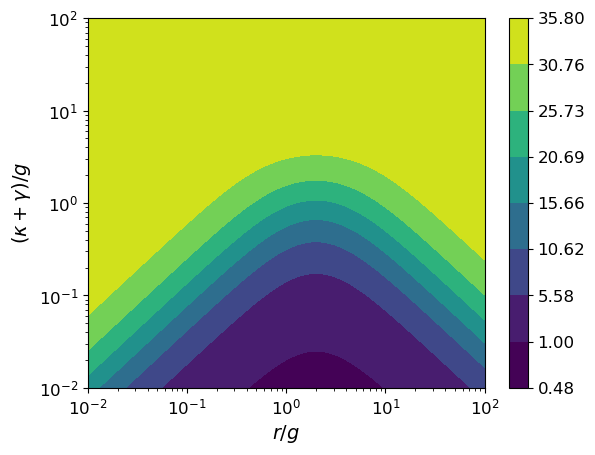

In [38]:
plt.contourf(αm, βm, scaled_nbar, [0.48, 1, 5.58, 10.62, 15.66, 20.69, 25.73, 30.76, 35.80])
plt.xlabel("$r / g$")
plt.xscale("log")
plt.ylabel("$(\\kappa + \\gamma) / g$")
plt.yscale("log")
plt.colorbar()

So it seems like there is a region of $r/g$ values that give the best cooling for a given $\gamma / g$, but it shrinks as the latter increases.  That seems reasonable.  Also worth noting that the peak of the region is pretty consistent as $\gamma / g$ increases.

We want to try and determine the optimal value of $r$ for a given set of parameters.  We can do this by turning the formula for $\bar{n}$ into a two parameter problem by defining $r = \alpha g$ and $M = \kappa + \gamma = \beta g$.  Then
$\bar{n} = \frac{\left[\alpha^2\beta + 4\beta + \alpha\beta^2\right]n_T + 4\alpha n_c}{(\alpha+\beta)(\alpha\beta + 4)}$.  We can then calculate the critical points of $\frac{d\bar{n}}{d\alpha}$ to obtain
$\alpha = \frac{\beta n_c \pm \sqrt{\beta^2n_c^2+4n_T^2+4n_Tn_c+\beta^2n_Tn_c}}{n_T}$.  The second derivative test can then be used to determine if these critical points correspond to minima or maxima.  This is
$\frac{d^2\bar{n}}{d\alpha^2} = \frac{(\alpha+\beta)(\alpha\beta + 4)^2(8\alpha\beta n_T - 8\beta^2 n_c)-2(4\alpha^2\beta n_T-16\beta n_T - 8\alpha\beta^2 n_T - 16\beta n_c - 4\beta^3n_c)(\alpha^2\beta+4\alpha+4\beta+\alpha\beta^2)(2\alpha\beta + \beta^2 + 4)}{\left[(\alpha+\beta)(\alpha\beta + 4)\right]^4}$.

In [39]:
def get_crit_points(β, nT, nc):
    c1 = β * nc + np.sqrt(β ** 2 * nc ** 2 + 4 * nT ** 2 + 4 * nT * nc + β ** 2 * nT * nc)
    c1 /= nT

    c2 = β * nc - np.sqrt(β ** 2 * nc ** 2 + 4 * nT ** 2 + 4 * nT * nc + β ** 2 * nT * nc)
    c2 /= nT

    return c1, c2

In [40]:
def get_second_deriv(α, β, nT, nc):
    num_a = (α ** 2 * β + 4 * α + 4 * β + α * β ** 2) * (8 * α * β * nT - 8 * β ** 2 * nc)
    num_b1 = 2 * (4 * α ** 2 * β * nT - 16 * β * nT - 8 * α * β ** 2 * nT - 16 * β * nc - 4 * β ** 3 * nc)
    num_b2 = (α ** 2 * β + 4 * α + 4 * β + α * β ** 2)
    num_b3 = 2 * α * β + β ** 2 + 4

    num = num_a - num_b1 * num_b2 * num_b3

    den = (α ** 2 * β + 4 * α + 4 * β + α * β ** 2) ** 4

    return num / den

In [41]:
# First set parameters
Q = np.logspace(4, 7, 1000)
γ = ωc / Q
g = 1e5
β = γ / g

In [42]:
# Calculate critical points for each value of β
crit_pts = get_crit_points(β, nT, nc)

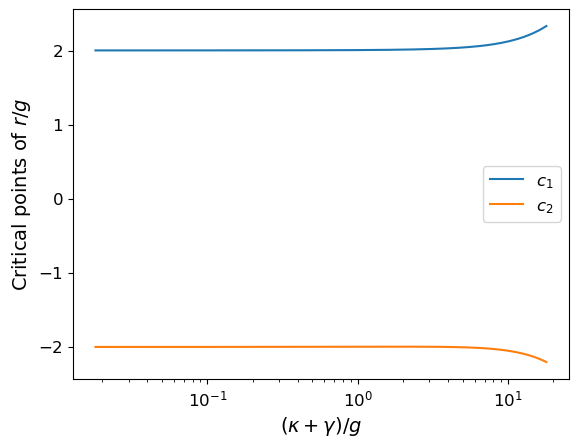

In [43]:
# Plot critical points
plt.semilogx(β, crit_pts[0], label="$c_1$")
plt.semilogx(β, crit_pts[1], label="$c_2$")
plt.xlabel("$(\\kappa + \\gamma) / g$")
plt.ylabel("Critical points of $r/g$")
plt.legend()

In [44]:
g = np.logspace(4, 7, 1000)
gm, Qm = np.meshgrid(g, Q)

γm = ωc / Qm
βm = γm / gm

In [45]:
crit_ptsm = get_crit_points(βm, nT, nc)

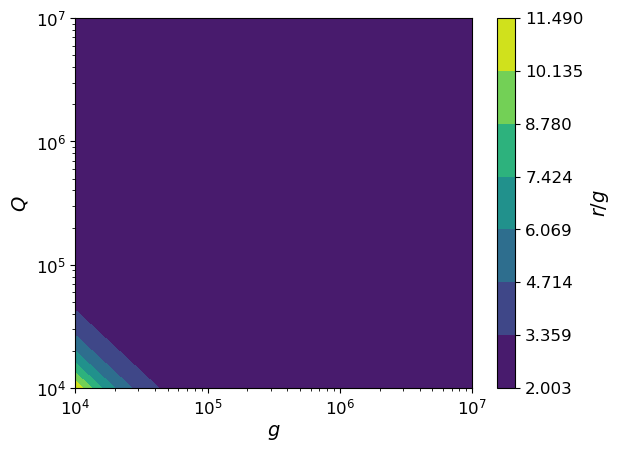

In [46]:
plt.contourf(gm, Qm, crit_ptsm[0], np.linspace(crit_ptsm[0].min(), crit_ptsm[0].max(), 8))
plt.xlabel("$g$")
plt.ylabel("$Q$")
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='$r/g$')

This confirms that $r/g \approx 2-3$ for the most part, although it does seem like there's an advantage to be had going to higher $r$ when you're at a low quality factor and coupling strength.

Now what happens to the cooling if you always use the optimal value for $r$?

In [47]:
P = 1
nc = 0.5 * (1 - P) / P

In [48]:
# Calculate the number of photons
nbar = full_mean_photons_cav(κ, γm, crit_ptsm[0]*gm, gm, nT, nc)

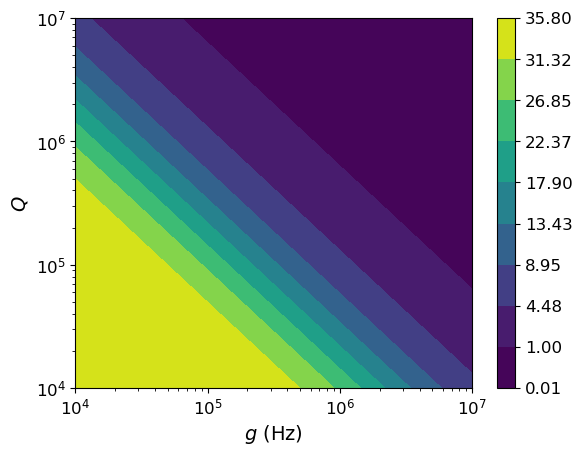

In [49]:
plt.contourf(gm, Qm, nbar, [nbar.min(), 1, 4.48, 8.95, 13.43, 17.90, 22.37, 26.85, 31.32, nbar.max()])
plt.xlabel("$g$ (Hz)")
plt.ylabel("$Q$")
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.savefig("nbar_vs_gQ_P=1_optimal_r.png", format='png', dpi=300)

In [50]:
P_vals = np.linspace(0.1, 1, 1000)
nc_vals = 0.5 * (1 - P_vals) / P_vals

In [51]:
# Define g and Q values we want to use here
g_vals = np.array([1e5, 1e6, 1e7])
Q_vals = np.array([1e5, 1e6, 1e7])
γ_vals = ωc / Q_vals

# Set up list for storing nbar values
nbars = []

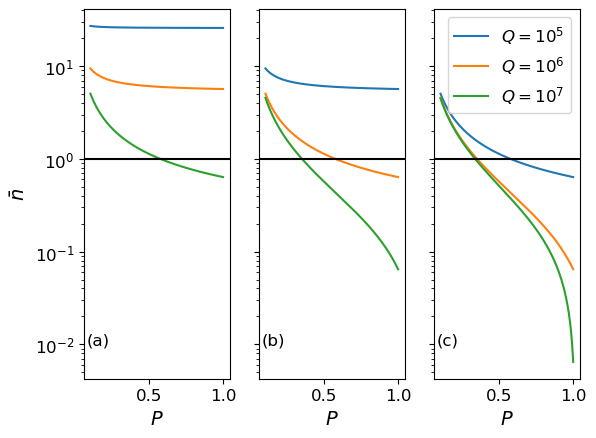

In [52]:
fig = plt.figure(1)
ax = fig.subplots(1, 3, sharey='all')
for i in range(g_vals.shape[0]):
    nbars = []
    for j in range(Q_vals.shape[0]):
        β = γ_vals[j] / g_vals[i]
        crit_pts = get_crit_points(β, nT, nc_vals)
        nbars.append(full_mean_photons_cav(κ, ωc / Q_vals[j], crit_pts[0] * g_vals[i], g_vals[i], nT, nc_vals))
        ax[i].semilogy(P_vals, nbars[j], label="$Q=10^" + str(j+5) + "$")
    ax[i].set_xlabel("$P$")
    ax[i].set_xticks([0.5, 1])
    ax[i].axhline(y=1, color='k')
ax[0].set_ylabel("$\\bar{n}$")
ax[2].legend()
ax[0].text(0.075, 0.01, '(a)')
ax[1].text(0.075, 0.01, '(b)')
ax[2].text(0.075, 0.01, '(c)')
fig.savefig("nbar_vs_P_for_diff_gQ_optimal_r.png", format='png', dpi=300)

In [53]:
# Want to determine more precisely the polarization required to get below nbar = 1
for i in range(g_vals.shape[0]):
    for j in range(Q_vals.shape[0]):
        for k in range(P_vals.shape[0]):
            β = γ_vals[j] / g_vals[i]
            crit_pts = get_crit_points(β, nT, nc_vals[k])
            n = full_mean_photons_cav(κ, ωc / Q_vals[j], crit_pts[0]*g_vals[i], g_vals[i], nT, nc_vals[k])
            if n < 1:
                print("g=" + str(g_vals[i]) + ", Q=" + str(Q_vals[j]) + ", P=" + str(P_vals[k]))
                break
    

g=100000.0, Q=10000000.0, P=0.5756756756756757
g=1000000.0, Q=1000000.0, P=0.5756756756756757
g=1000000.0, Q=10000000.0, P=0.34864864864864864
g=10000000.0, Q=100000.0, P=0.5756756756756757
g=10000000.0, Q=1000000.0, P=0.34864864864864864
g=10000000.0, Q=10000000.0, P=0.33513513513513515


So choosing the optimum $r$ didn't have as big an impact as I had hoped.  This makes sense though because the previous calculations assumed $r/g \approx 2$ anyway, which is pretty close for most values of $g$ and $Q$ that we looked at.

What if we compare to using something like r/g = 3 or 4 instead?  How does that change the results?

In [54]:
nbar_r4g = full_mean_photons_cav(κ, γm, 4*gm, gm, nT, nc)

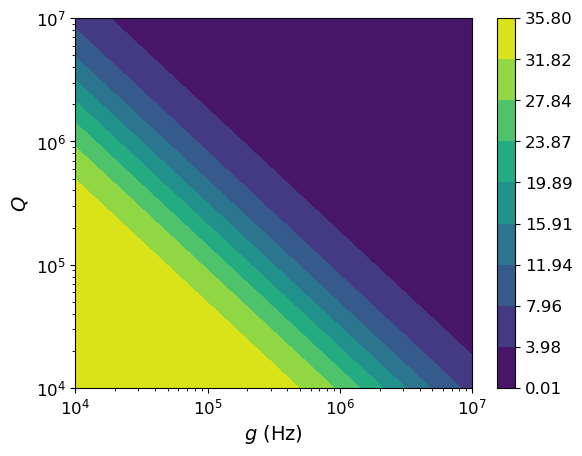

In [55]:
plt.contourf(gm, Qm, nbar_r4g, np.linspace(nbar_r4g.min(), nbar_r4g.max(), 10))
plt.xlabel("$g$ (Hz)")
plt.ylabel("$Q$")
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.savefig("nbar_vs_gQ_P=1_r=4g.png", format='png', dpi=300)

Okay, let's pick $Q=10^5$ and vary $g$ for several fixed values of $r/g$ and compare those results to those obtained using the optimal choice.

In [56]:
# Define Q and γ.  Also make sure that nT and nc are correct here
Q = 1e5
γ = ωc / Q
T = 5
nT = photons_from_temp(ωc, T)
P = 1
nc = 0.5 * (1 - P) / P

In [57]:
# Define g
g = np.logspace(4, 7, 1000)

# Get the critical points
crit_pts = get_crit_points(γ / g, nT, nc)[0]

In [58]:
# Calculate nbar for different values of r/g
nbar_r2g = full_mean_photons_cav(κ, γ, 2*g, g, nT, nc)
nbar_r10thg = full_mean_photons_cav(κ, γ, 0.1*g, g, nT, nc)
nbar_r10g = full_mean_photons_cav(κ, γ, 10*g, g, nT, nc)
nbar_ropt = full_mean_photons_cav(κ, γ, crit_pts*g, g, nT, nc)

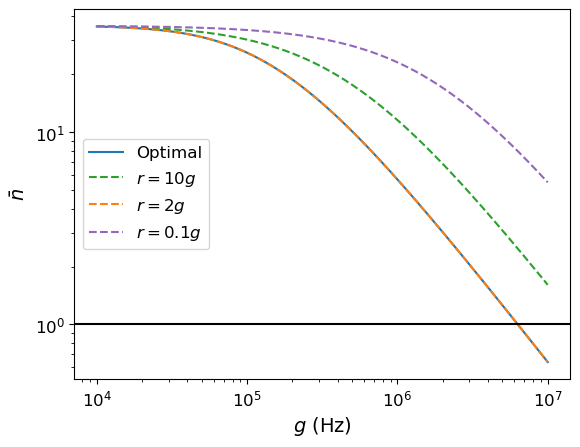

In [59]:
# Plot
plt.plot(g, nbar_ropt, color='tab:blue', label='Optimal')
plt.plot(g, nbar_r10g, '--', color='tab:green', label='$r=10g$')
plt.plot(g, nbar_r2g, '--', color='tab:orange', label='$r=2g$')
plt.plot(g, nbar_r10thg, '--', color='tab:purple', label='$r=0.1g$')
plt.axhline(y=1, color='k')
plt.xlabel("$g$ (Hz)")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("$\\bar{n}$")
plt.legend()
plt.savefig('nbar_vs_g_Q=1e5_diff_rovg.png', dpi=300, format='png')

In [60]:
# Want to check Q = 1e4
Q = 1e4
γ = ωc / Q

In [61]:
# Define g
g = np.logspace(4, 7, 1000)

# Get the critical points
crit_pts = get_crit_points(γ / g, nT, nc)[0]

In [62]:
# Calculate nbar for different values of r/g
nbar_r2g = full_mean_photons_cav(κ, γ, 2*g, g, nT, nc)
nbar_r10thg = full_mean_photons_cav(κ, γ, 0.1*g, g, nT, nc)
nbar_r10g = full_mean_photons_cav(κ, γ, 10*g, g, nT, nc)
nbar_ropt = full_mean_photons_cav(κ, γ, crit_pts*g, g, nT, nc)

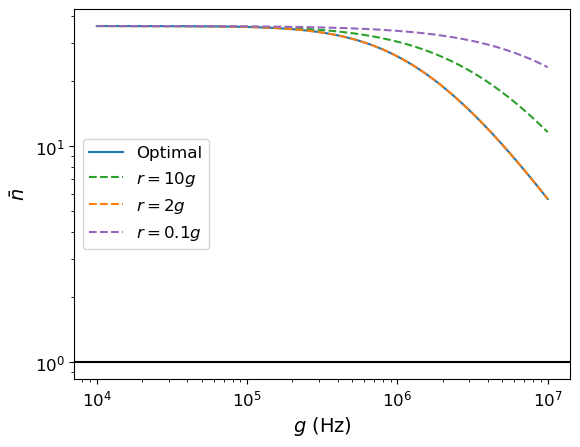

In [78]:
# Plot
plt.plot(g, nbar_ropt, color='tab:blue', label='Optimal')
plt.plot(g, nbar_r10g, '--', color='tab:green', label='$r=10g$')
plt.plot(g, nbar_r2g, '--', color='tab:orange', label='$r=2g$')
plt.plot(g, nbar_r10thg, '--', color='tab:purple', label='$r=0.1g$')
plt.axhline(y=1, color='k')
plt.xlabel("$g$ (Hz)")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("$\\bar{n}$")
plt.legend()

Want to check what happens if you minimize with respect to $\beta$.

In [64]:
def get_crit_points_β(α, nT, nc):
    a = -(α ** 2 * nT + 4 * nT - 2 * α * nc)
    b = np.sqrt((α ** 2 * nT + 4 * nT - 2 * α * nc) ** 2 + 4 * α * nT * (α ** 2 * nc - 4 * nc))
    den = 2 * α * nT
    return (a + b) / den, (a - b) / den

In [65]:
T = 5
nT = photons_from_temp(ωc, T)
P = 1
nc = 0.5 * (1 - P) / P

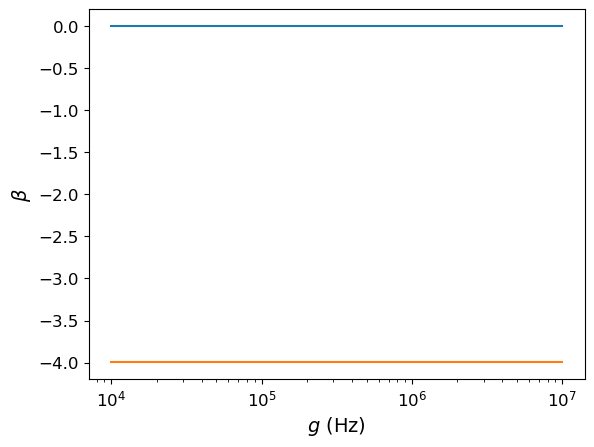

In [81]:
g = np.logspace(4, 7, 1000)
crit_points = get_crit_points_β(2 * g / g, nT, nc)
plt.plot(g, crit_points[0])
plt.plot(g, crit_points[1])
plt.xlabel("$g$ (Hz)")
plt.ylabel("$\\beta$")
plt.xscale('log')

Given a set of cavity parameters, what is the greatest temperature we can set the cavity to while still achieving $\bar{n} < 1$?

In [67]:
def thermal_photons_from_cav(nbar, κ, γ, r, g, nc):
    """
    function for calculating the thermal photons for a given number of photons in the cavity and other parameters
    """
    num = (r + κ + γ) * ((κ + γ) * r / 4 + g ** 2) * nbar - r * g ** 2 * nc
    den = r * (κ + γ) ** 2 /4 + (κ + γ) * g ** 2 + (κ + γ) * r ** 2 / 4
    return num / den

In [68]:
κ = 0
Q = 5e4
γ = ωc / Q
g = 5e7
r = 2 * g
P = 0.7
nc = 0.5 * (1 - P) / P

In [69]:
n_req = thermal_photons_from_cav(1, κ, γ, r, g, nc)
T_req = temp_from_photons(ωc, n_req)
print("Temp required to get $\\bar{n} < 1$: ", T_req) 

Temp required to get $\bar{n} < 1$:  15.184692860679002


In [70]:
temp_from_photons(ωc, 1)

0.19873429296841896

We assume that resonant cooling ($\Delta = 0$) is the best for mode cooling, but I just want to make sure that that is the case.  Unfortunately, analytically solving the integral seems intractable, but we can do some numeric integration to check.

In [71]:
# Define parameters
ωc = 2.87 * 2 * np.pi * 1e9
κ = 0
P = 0.8
nc = 0.5 * (1 - P) / P
T = 5
nT = photons_from_temp(ωc, T)
Q = 1e6
γ = ωc / Q
g = 1e6
r = 2 * g

In [72]:
ω = np.linspace(-4, 4, 1000) * 1e6 * 2 * np.pi
Δ = np.linspace(-1, 1, 1000) * 1e6 * 2 * np.pi

In [73]:
nbar_vs_Δ = np.zeros(Δ.shape[0])
for i in range(Δ.shape[0]):
    spec = cav_spectrum(ω, κ, γ, r, g, nT, nc, Δ[i])
    nbar_vs_Δ[i] = integrate.simpson(spec, x=ω)

Text(0, 0.5, '$\\bar{n}$')

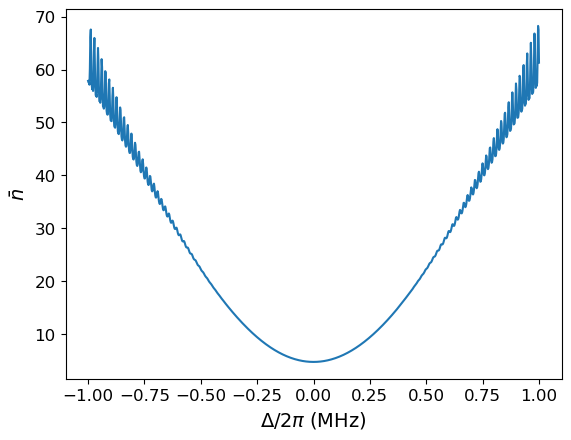

In [74]:
plt.plot(Δ / (1e6*2*np.pi), nbar_vs_Δ)
plt.xlabel("$\\Delta / 2\\pi$ (MHz)")
plt.ylabel("$\\bar{n}$")